# Pair-trading model

В этом ноутбуке мы используем фильтр Кащмана для оценки модели для парной торговли. Модель будем использовать такую - SSM (state space model):

$$y_t = H^{'}_t\xi_t + \epsilon_t$$

$$\xi_{t+1} = F_{t+1}\xi_t + \omega_t$$

Где,

$$\xi_t = \begin{bmatrix}
    \beta_{1t} \\
    l_{1t} \\
    ... \\
    \beta_{nt} \\
    l_{nt}
\end{bmatrix}, \ \ \ \ \
H^{'}_t = \begin{bmatrix}
    x_{1t}       & 1 & 0 & 0 & \dots & 0 & 0 \\
    0       & 0 & x_{2t} & 1 &\dots & 0 & 0\\
    ... \\
    0       & 0 &0 & 0 & \dots & x_{nt} & 1
\end{bmatrix}, \ \ \ \ \
F_{t+1} = \begin{bmatrix}
    1 & 0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 1 & 0 & 0 &\dots & 0 & 0\\
    ... \\
    0 & 0 & 0 & 0 & \dots & 0 & 1
\end{bmatrix}
$$

Эта модель фактически может быть представлена в отдельности для каждой из пар $(x,y)$ в отдельности. Её вид будет таким:

$$y_{i,t} = \beta_{i,t} x_{it} + l_{i,t} + \epsilon_{i,t}$$

$$\beta_{i,t+1} = \beta_{i,t} + u_{i,t}$$

$$l_{i,t+1} = l_{i,}t + v_{i,t}$$


------------------------------------------------------------------------------------

Алгоритм который мы реализуем здесь:

* На вход подаются две матрицы X, Y - матрицы (t, price) активов
* Считаем std по каждому $y \in Y$
* Находим оптимальный вектор параметров для фильтра Калмана. Параметры будут связаны с волатильностью, поэтому мерять их будем в волатильности базы
* записываем в файл оптимальные оценки beta_t, и l_t

In [6]:
import theano 
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [7]:
# for debug: may be useful ->
# -> theano.config.optimizer='None'
# -> theano.config.exception_verbosity='high'

### 1. Prepare the data

In [69]:
# number of (Y, X) pairs, see the header
n = 7

In [70]:
def simul():
    '''
        simulates X, Y time series from model described in header
        Returns: tuple (y, x)
        
    '''
    N = int(6.5 * 4 * 125)
    beta = 0.5
    x_sigma, beta_sigma, level_sigma, err_sigma = 5., .02, 1., 10.
    x = np.random.randn(N) * x_sigma

    err = np.random.randn(N) * err_sigma
    beta = 1. + np.random.randn(N).cumsum() * beta_sigma
    level = np.random.randn(N).cumsum() * level_sigma
    y = beta*x + level + err
    return y, x, beta

In [71]:
data = [simul() for i in range(n)]
Y = np.hstack([yx[0].reshape(-1, 1) for yx in data]).astype('float32')
X = np.hstack([yx[1].reshape(-1, 1) for yx in data]).astype('float32')
B = np.hstack([yx[2].reshape(-1, 1) for yx in data]).astype('float32')

In [72]:
Y.shape, X.shape

((3250, 7), (3250, 7))

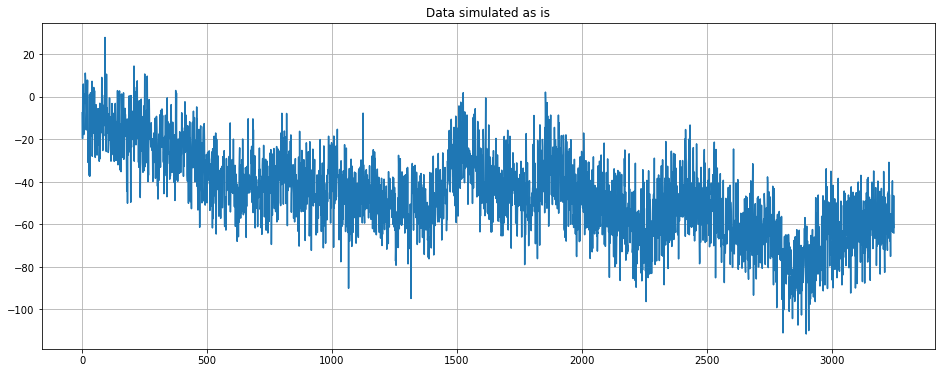

In [73]:
plt.figure(figsize=(16, 6))
plt.grid()
plt.title('Data simulated as is')
plt.plot(Y[:, 0])

### 2. Y standard deviation

In [74]:
sigmas = Y.std(axis=0)

In [75]:
GRID_SIZE = 10
optim_grid = np.hstack([np.linspace(0., 1., GRID_SIZE)[1:].reshape(-1, 1) for i in range(n)]) * sigmas 

In [76]:
beta_cells = [] 
for i in range(n):
    y, x = Y[:, i], X[:, i]
    beta_cells.append(LinearRegression().fit(x.reshape(-1, 1), y.reshape(-1, 1)).coef_.ravel()[0] / np.sqrt(x.shape[0]))

### 3. Optim procedure for Kalman

In [77]:
class kalman:        

    def kalman_rec(self, y_t, H_t, xi_t_tm1, P_t_tm1, F_tp1, Q_t, R_t):
        # for debug: may be useful ->
        # -> print(y_t.ndim, H_t.ndim, F_tp1.ndim, Q_t.ndim, R_t.ndim, xi_t_tm1.ndim, P_t_tm1.ndim)

        y_t_hat = T.dot(H_t.T, xi_t_tm1)
        eps_t = y_t - y_t_hat
        pseudo_inv = T.nlinalg.matrix_inverse(T.dot(H_t.T, T.dot(P_t_tm1, H_t)) + R_t)
        invi =  T.dot(P_t_tm1, T.dot(H_t, pseudo_inv))
        xi_t_t = xi_t_tm1 + T.dot(invi, eps_t)
        xi_tp1_t = T.dot(F_tp1, xi_t_t)
        P_t_t = P_t_tm1 - T.dot(invi, T.dot(H_t.T, P_t_tm1))
        P_tp1_t = T.dot(F_tp1, T.dot(P_t_t, F_tp1.T)) + Q_t

        return [xi_tp1_t, P_tp1_t, y_t_hat, xi_t_t, T.sqr(eps_t)]
    
    def __init__(self, Y, X):
        self.Y, self.X = Y[:, :, np.newaxis], X
        y, H = T.tensor3(), T.tensor3()
        F, Q, R = T.matrix(), T.matrix(), T.matrix()
        sequences=[dict(input=y, taps=[0]), dict(input=H, taps=[0])]
        xi_1_0 = T.matrix()
        P_1_0 = T.matrix()
        (values, updates) = theano.scan(fn=self.kalman_rec,
                                          sequences=sequences,
                                          outputs_info=[xi_1_0, P_1_0, None, None, None],
                                          non_sequences=[F, Q, R],
                                          strict=True)
        self.kalman_filter = theano.function([y, H, xi_1_0, P_1_0, F, Q, R], values, updates=updates, allow_input_downcast=True)
        
    def get_G_mat(self, x):
        G = np.zeros((n, 2*n), dtype='float32')
        source = np.hstack([x.reshape(-1, 1), np.ones((x.shape[0], 1))])
        for i in range(n):
            G[i, i* 2] = source[i, 0]
            G[i, i* 2+1] = source[i, 1]
        return G
    
    def filter_out(self, Q, R):
        # init all variables need
        H_val = np.array([self.get_G_mat(self.X[t]).T for t in range(self.X.shape[0])])
        F_val = np.diag(np.ones(2*n, dtype='float32'))
        
        xi_1_0_val = np.zeros((2*n, 1))
        P_1_0_val = np.diag(np.ones(2*n))
        # for debug: may be useful ->
        # -> print('Shapes:\n')
        # -> print(' y : {}\n H : {}\n xi_1_0 : {}\n P_1_0 : {}\n F : {}\n Q : {}\n R : {}\n'.format(*map(\
        #                            lambda d: d.shape, [self.Y, H_val, xi_1_0_val, P_1_0_val, F_val, Q, R])))
        start_time = time.time()
        output = self.kalman_filter(self.Y, H_val, xi_1_0_val, P_1_0_val, F_val, Q, R)
        # for debug: may be useful ->
        # -> print('Eval time: {} s.'.format(time.time() - start_time))
        return output

In [78]:
model = kalman(Y, X)

In [97]:
min_errs = np.array([np.infty] * n)
opt_node = {}
level = {}
beta = {}

for k, node in enumerate(optim_grid):
    R = np.diag(node)
    trace = np.zeros(2*n)
    trace[::2] = node * 0.1
#    trace[slice(1, None, 2)] = np.array(beta_cells) 
    Q = np.diag(trace)
    output = model.filter_out(Q, R)
    
    errs = output[-1].mean(axis=0).ravel()
    for i, (cur_err, min_err) in enumerate(zip(errs, min_errs)):
        if cur_err < min_err:
            min_errs[i] = cur_err
            opt_node[i] = k
            #print(output[-2].shape)
            beta[i] = output[-2][:, 2*i]
            level[i] = output[-2][:, 2*i+1]
    


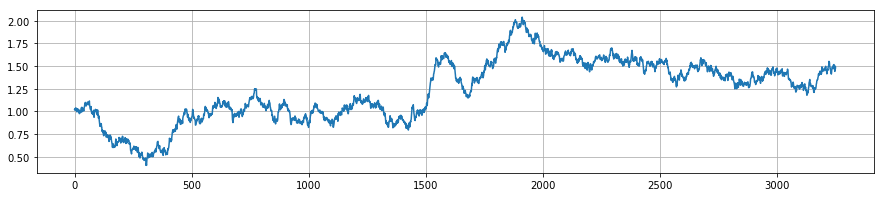

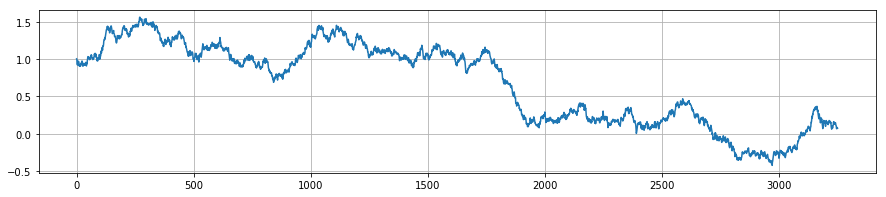

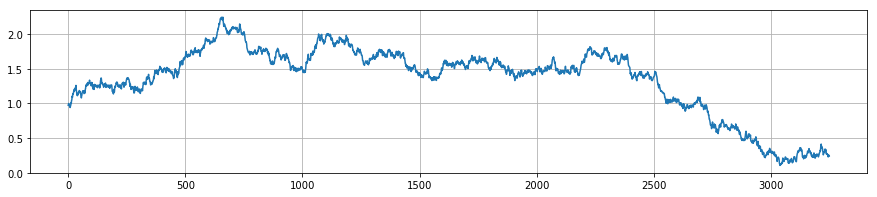

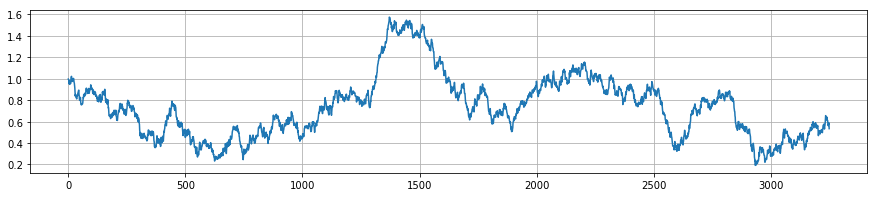

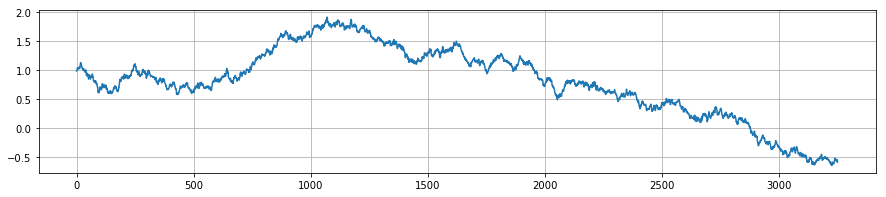

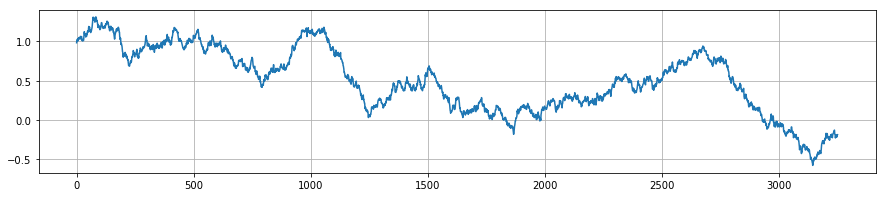

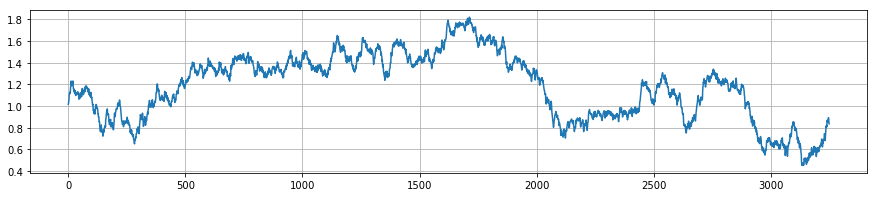

In [98]:
for i in range(n):
    y, x = Y[:, i], X[:, i]
    plt.figure(figsize=(15, 3))
    plt.grid()

    plt.plot(B[:, i].ravel())


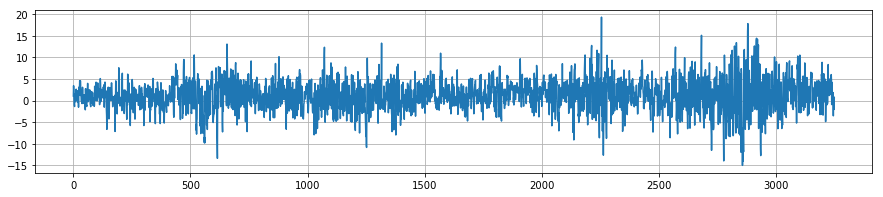

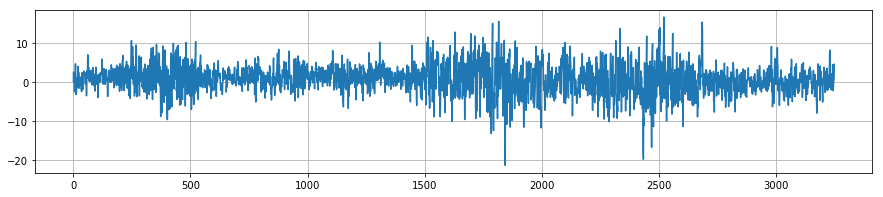

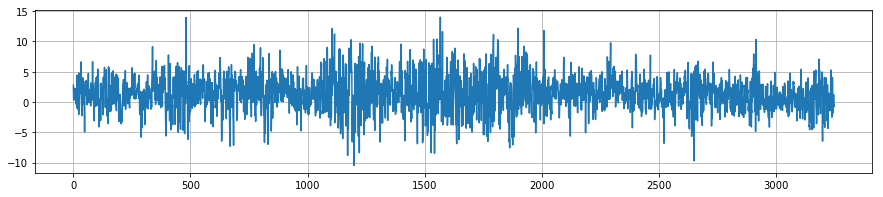

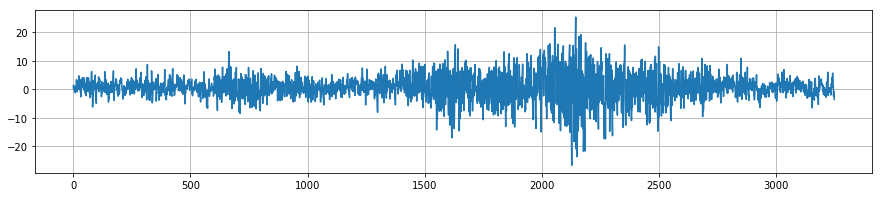

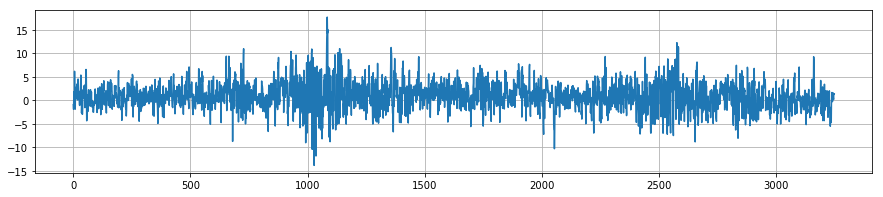

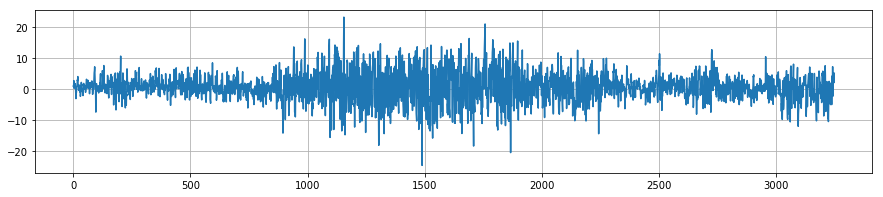

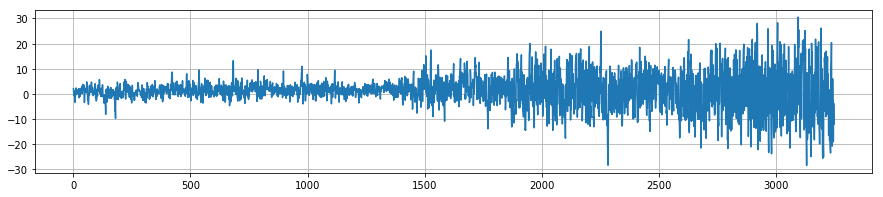

In [99]:
for i in range(n):
    y, x = Y[:, i], X[:, i]
    plt.figure(figsize=(15, 3))
    plt.grid()

    plt.plot(beta[i].ravel())


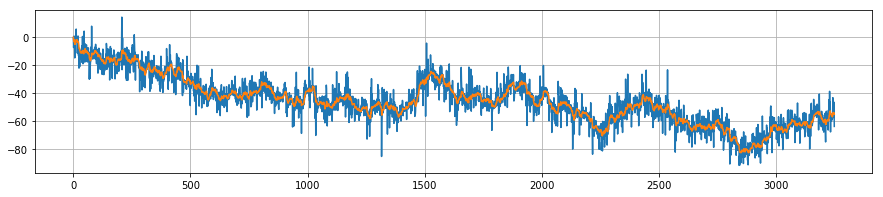

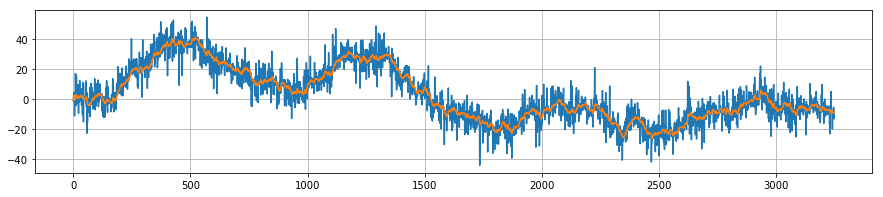

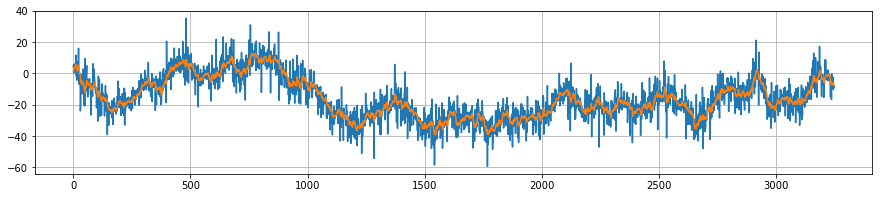

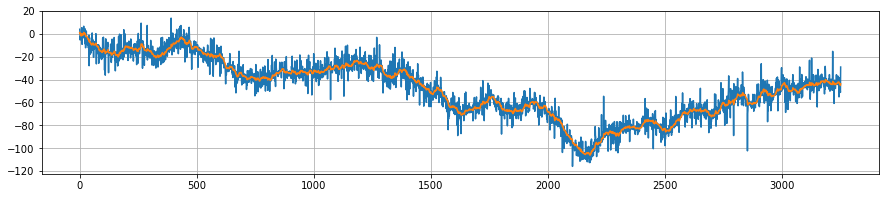

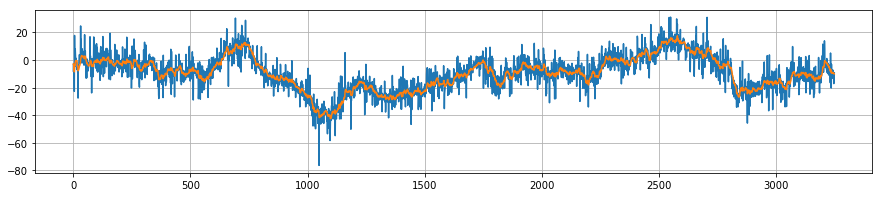

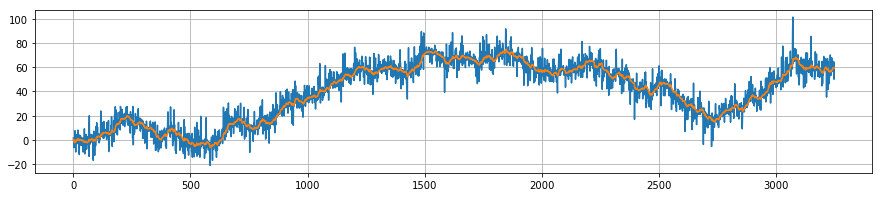

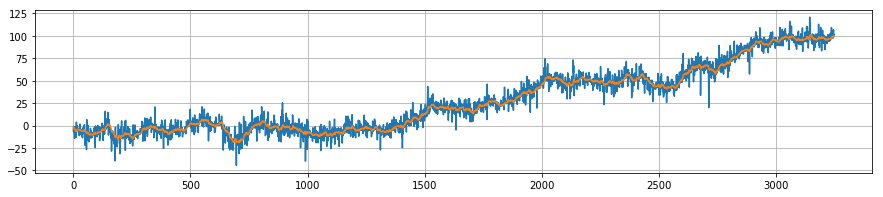

In [96]:
for i in range(n):
    y, x = Y[:, i], X[:, i]
    plt.figure(figsize=(15, 3))
    plt.grid()

    plt.plot(y - beta[i].ravel() * x)
    plt.plot(level[i].ravel())